# Simple shortest path LP (as MCNF)

Here we implement the simple shortest path LP as a min cost network flow problem

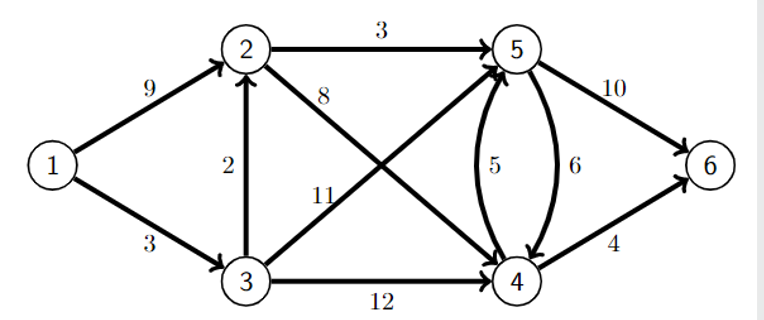

In [2]:

N = [i for i in 1:6]
A = [(1,2), (1,3), (2,4), (2,5), (3,2), (3,4), (3,5), (4,5), (4,6), (5,4), (5,6)]

# Put in the lengths
c = Dict((1,2) => 9, 
(1,3) => 3,
(2,4) => 8,
(2,5) => 3,
(3,2) => 2,
(3,4) => 12,
(3,5) => 11,
(4,5) => 5,
(4,6) => 4,
(5,4) => 6,
(5,6) => 10
)

# Put in the "net supply", most zero.
b = Dict(i => 0 for i in N)
b[1] = 1
b[6] = -1

# Lower bounds
L = Dict(a => 0 for a in A)

# Upper Bounds (can be 1 or infinity)
U = Dict(a => Inf for a in A)




Dict{Tuple{Int64, Int64}, Float64} with 11 entries:
  (4, 5) => Inf
  (1, 2) => Inf
  (2, 5) => Inf
  (1, 3) => Inf
  (4, 6) => Inf
  (3, 5) => Inf
  (2, 4) => Inf
  (3, 2) => Inf
  (3, 4) => Inf
  (5, 6) => Inf
  (5, 4) => Inf

Now just use a "standard" MCNF model 
$$\min \sum_{i,j \in A} c_{ij} x_{ij}$$

$$\sum_{j  :  (i,j) \in A} x_{ij} - \sum_{j  :  (j,i) \in A} x_{ji} = b_i \quad \forall i \in N$$

$$L_{ij} \leq x_{ij} \leq U_{ij} \quad \forall (i,j) \in A$$


In [3]:
using JuMP, HiGHS
m = Model(HiGHS.Optimizer)
@variable(m, x[a in A])
# Set bounds like this
for a in A 
    set_lower_bound(x[a], L[a])
    if U[a] < Inf
        set_upper_bound(x[a], U[a])
    end
end

@objective(m, Min, sum(c[a]*x[a] for a in A))
@constraint(m, flow_balance[i in N], sum(x[(i,j)] for j in N if (i,j) in A) - sum(x[(j,i)] for j in N if (j,i) in A) == b[i])

set_silent(m)
optimize!(m)

println("Shortest Path has length: ",round(objective_value(m),digits=2))
for a in A 
    if value(x[a]) > 0.1
        println("Uses arc: ", a)
    end
end

Shortest Path has length: 17.0
Uses arc: (1, 3)
Uses arc: (2, 4)
Uses arc: (3, 2)
Uses arc: (4, 6)


# Single-source all destination shortest path

It's also very easy to do shortest path from a given node $s$ to all other nodes $i \in N$
Just set $b_s = n-1$ and $b_i = -1 \forall i \neq s \in N$

In [4]:
# Put in the "net supply", most zero.
b[1] = length(N) - 1
for i in 2:6
    b[i] = -1
end 

# We could build from scratch, but let's just try to change the RHS in JuMP
# https://jump.dev/JuMP.jl/stable/reference/constraints/#JuMP.set_normalized_rhs

for i in N
    set_normalized_rhs(flow_balance[i], b[i])
end

optimize!(m)

println("Shortest Path Tree has length: ",round(objective_value(m),digits=2))
for a in A 
    if value(x[a]) > 0.1
        println("Uses arc: ", a)
    end
end


Shortest Path Tree has length: 46.0
Uses arc: (1, 3)
Uses arc: (2, 4)
Uses arc: (2, 5)
Uses arc: (3, 2)
Uses arc: (4, 6)
